In [337]:

import tensorflow as tf
from tensorflow import keras
import time
tf.get_logger().setLevel(40) # suppress deprecation messages
from tensorflow import keras
from keras.models import Model, load_model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.neighbors import DistanceMetric
# from tslearn.datasets import UCR_UEA_datasets
# from tslearn.neighbors import NearestNeighbors, KNeighborsTimeSeries, KNeighborsTimeSeriesClassifier
from tslearn.neighbors import KNeighborsTimeSeries
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
# from counterfactual_utils import label_encoder, ucr_data_loader
# from XAI_thesis_project.Instance-Based_CFE_TSC.counterfactual_utils import label_encoder, ucr_data_loader
# from Native_Guide.Native_Guide_Methods.counterfactual_utils import label_encoder, ucr_data_loader
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.11.0
Eager execution enabled:  True


In [338]:
import config
from process_data import *

"""
Configuration
"""
dataset_name = "ECG200"
class_names = config.class_names
classifier_name = "KNN"
random_seed = 222
test_id = 678
save_cls = False
## SSSS
pos_indice = []
neg_indice = []

"""
1 - Process dataset and get processed data
"""
X_train, y_train, X_test, y_test = process_ucr_dataset(dataset_name)
y_train = Unify_class_names(y_train, dataset_name=dataset_name)
y_test = Unify_class_names(y_test, dataset_name=dataset_name)
positive_nums, negative_nums = get_dataset_info_group_by_class(y_train)
print("Positive nums: ", positive_nums, "Negative nums: ", negative_nums)
seq_length = X_train.iloc[0][0].shape[0]
print("Dataset: ", dataset_name)
print("Random Seed: ", random_seed)

for idx, label in enumerate(y_test):
    if label == '1':
        pos_indice.append(idx)
    else:
        neg_indice.append(idx)
print("Positive instance ids: ", pos_indice)
print("Negative instance ids: ", neg_indice)

Positive nums:  10 Negative nums:  10
Dataset:  MoteStrain
Random Seed:  111
Positive instance ids:  [1, 4, 5, 11, 12, 13, 14, 16, 18, 19, 24, 25, 31, 32, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 51, 56, 57, 61, 64, 65, 66, 67, 68, 69, 70, 71, 74, 77, 79, 83, 84, 85, 86, 87, 89, 91, 92, 93, 96, 97, 100, 101, 105, 106, 108, 109, 110, 111, 112, 113, 114, 118, 119, 124, 125, 126, 127, 128, 129, 130, 131, 132, 134, 136, 137, 139, 142, 143, 145, 146, 148, 149, 150, 151, 154, 156, 157, 158, 161, 163, 166, 168, 170, 172, 173, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 198, 199, 203, 204, 205, 207, 212, 214, 215, 217, 219, 223, 224, 227, 229, 231, 232, 233, 234, 236, 239, 240, 241, 242, 243, 251, 252, 255, 263, 264, 266, 267, 268, 273, 276, 278, 280, 281, 282, 283, 284, 285, 286, 289, 291, 292, 294, 297, 300, 301, 302, 304, 305, 307, 310, 311, 313, 314, 315, 317, 322, 323, 329, 330, 332, 333, 334, 335, 338, 342, 343, 344, 345, 346, 349, 351, 352,

In [339]:
from sktime.classification.interval_based import DrCIF
from sktime.classification.feature_based import Catch22Classifier
from sklearn.ensemble import RandomForestClassifier
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sktime.classification.deep_learning.cnn import CNNClassifier
assert classifier_name in ["KNN", "CNN", "DrCIF", "Catch22"]
clf = None
if classifier_name == "KNN":
    # (1) KNN-l2
    clf = KNeighborsTimeSeriesClassifier(distance="euclidean")
elif classifier_name == "CNN":
    # (2) CNN
    clf = CNNClassifier(random_state=random_seed)
elif classifier_name == "DrCIF":
    # (3) DrCIF
    clf = DrCIF(
        n_estimators=3, n_intervals=2, att_subsample_size=2, random_state=random_seed
    )
elif classifier_name == "Catch22":
    # (4) Catch22
    clf = Catch22Classifier(
        estimator=RandomForestClassifier(n_estimators=5),
        outlier_norm=True,
        random_state=random_seed
    ) 
 
print("(1) Training classifier " , classifier_name, " ......", clf)
print()
classifier_path = "Classifiers_Models/" + classifier_name + "/" + classifier_name + "_" + dataset_name + "_" + str(random_seed)
if save_cls:
    print("Fitting model ...", )
    clf.fit(X_train, y_train)
    clf.save(path=classifier_path)
    print("Model saved to ", classifier_path)
else:
    clf = clf.load_from_path(classifier_path + ".zip")
    print("Loading model at " + classifier_path)
y_pred = clf.predict(X_test)
print("Report: ")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=class_names))
print()

(1) Training classifier  CNN  ...... CNNClassifier(random_state=111)

Loading model at Classifiers_Models/CNN/CNN_MoteStrain_111
79/79 [==============================] - 0s 1ms/step
Report: 
              precision    recall  f1-score   support

           1       0.94      0.84      0.89       577
          -1       0.87      0.95      0.91       675

    accuracy                           0.90      1252
   macro avg       0.91      0.90      0.90      1252
weighted avg       0.90      0.90      0.90      1252




In [340]:
# Specify a to-be-explained instance from test set.

instance_id = test_id # Test set instance
to_be_explained_instance = X_test.iloc[instance_id][0].values.reshape(1, 1, seq_length)
to_be_explained_instance_label_y = y_test[instance_id]
to_be_explained_instance_predicted_y = clf.predict(to_be_explained_instance)[0]
from copy import copy
# original_instance = copy(to_be_explained_instance)
target_y = "1" if int(to_be_explained_instance_predicted_y) == -1 else "-1"
print("To-be-explained_instance_id: ", instance_id, ", Predicted: ", to_be_explained_instance_predicted_y, ", Truth: ", to_be_explained_instance_label_y, ", Target: ", target_y)
print()

1/1 [==============================] - 0s 18ms/step
To-be-explained_instance_id:  222 , Predicted:  -1 , Truth:  -1 , Target:  1



In [341]:
# df to numpy
from sktime.datatypes._panel._convert import from_nested_to_2d_array
X_train_float = from_nested_to_2d_array(X_train).to_numpy()
X_test_float = from_nested_to_2d_array(X_test).to_numpy()
X_train = X_train_float
X_test = X_test_float
X_train.shape

(20, 84)

In [342]:
#finding the nearest unlike neighbour. NB will need to account for regularization
# def native_guide_retrieval(query, predicted_label, distance, n_neighbors):
def native_guide_retrieval(query, predicted_label, distance, n_neighbors):
    
    df = pd.DataFrame(y_train, columns = ['label'])
    df.index.name = 'index'
    #df[df['label'] == 1].index.values, df[df['label'] != 1].index.values
    
    # ts_length = X_train.shape[1]
    ts_length = seq_length
    
    knn = KNeighborsTimeSeries(n_neighbors=n_neighbors, metric = distance)
    
    knn.fit(X_train[list(df[df['label'] != predicted_label].index.values)])
    
    dist,ind = knn.kneighbors(query.reshape(1,ts_length), return_distance=True)
    return dist[0], df[df['label'] != predicted_label].index[ind[0][:]]

In [343]:
# native_guide_retrieval(X_test[12], y_pred[12], 'dtw', 1)
# find instance closest to to-be-explained instance (different class)
target_dist, target_idx = native_guide_retrieval(to_be_explained_instance, to_be_explained_instance_label_y, 'dtw', 1)
target_dist, target_idx.tolist()[0]


e:\Software\AboutPrograming\Anaconda3\envs\sktime310\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(


(array([6.73549544]), 10)

In [344]:
# Check if it is a match
print("To-be-explained_instance_id: ", instance_id, ", Predicted: ", to_be_explained_instance_predicted_y, ", Truth: ", to_be_explained_instance_label_y, ", Target: ", target_y)
print("Predicted: ", y_pred[instance_id], ", Truth: ", y_test[instance_id], ", Target: ", y_train[target_idx.tolist()[0]])
# plt.plot(to_be_explained_instance.squeeze(), c='blue')

To-be-explained_instance_id:  222 , Predicted:  -1 , Truth:  -1 , Target:  1
Predicted:  -1 , Truth:  -1 , Target:  1


In [345]:
# (1) find instance closest to to-be-explained instance (same class), i.e., nearest neibour (NN)
knn = KNeighborsTimeSeries(n_neighbors=1, metric='dtw').fit(X_train)
dist_test, sim_idx = knn.kneighbors(X_test[instance_id].reshape(1,-1), return_distance=True)
dist_test, sim_idx

e:\Software\AboutPrograming\Anaconda3\envs\sktime310\lib\site-packages\tslearn\utils\utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 1 1-dimensional timeseries
  warnings.warn(


(array([[3.23639655]]), array([[18]], dtype=int64))

In [346]:
np.where(y_test != y_pred)

(array([   7,    8,   26,   29,   42,   60,   70,   76,   81,   82,   91,
         103,  104,  106,  107,  114,  121,  124,  138,  141,  145,  156,
         160,  164,  165,  167,  174,  185,  190,  201,  211,  220,  226,
         230,  248,  250,  259,  261,  262,  271,  293,  312,  318,  319,
         340,  341,  352,  365,  402,  408,  425,  429,  442,  450,  487,
         488,  490,  496,  505,  523,  529,  530,  531,  536,  572,  576,
         585,  612,  621,  629,  631,  662,  664,  672,  682,  686,  688,
         691,  693,  698,  725,  726,  736,  745,  769,  797,  825,  826,
         831,  839,  871,  882,  885,  894,  944,  958,  962,  993, 1000,
        1006, 1021, 1059, 1070, 1071, 1077, 1080, 1110, 1116, 1119, 1123,
        1125, 1137, 1139, 1159, 1163, 1164, 1172, 1181, 1182, 1197, 1206,
        1208, 1224, 1228, 1237], dtype=int64),)

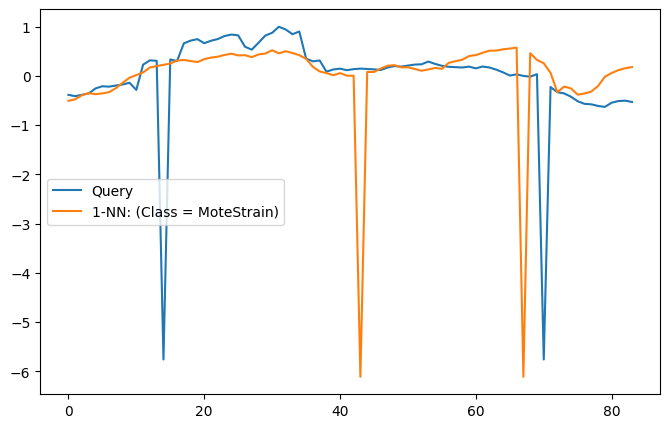

In [347]:
plt.figure(figsize=(8,5))
plt.plot(X_test[instance_id], label = 'Query')
plt.plot(X_train[sim_idx.tolist()[0][0]], label = '1-NN: (Class = ' + dataset_name + ")")
plt.legend()

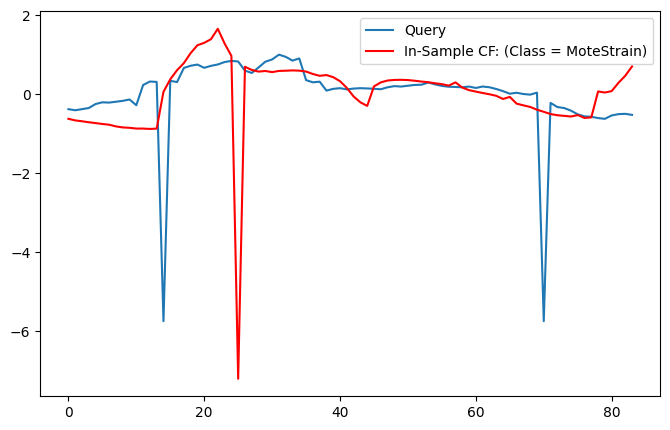

In [348]:
plt.figure(figsize=(8,5))
plt.plot(to_be_explained_instance.squeeze(), label = 'Query')
plt.plot(X_train[target_idx.tolist()[0]], c='red', label='In-Sample CF: (Class = ' + dataset_name + ")")
plt.legend()

In [349]:
from tslearn.barycenters import dtw_barycenter_averaging

In [350]:
# def target_(instance):
#     target = np.argsort((model.predict_proba(instance.reshape(1,-1))))[0][-2:-1][0] 
#     return target

In [351]:
str(target_y), to_be_explained_instance_predicted_y

('1', '-1')

In [352]:
to_be_explained_instance = to_be_explained_instance.squeeze()
to_be_explained_instance.shape

(84,)

### DTW-Case (Simple 1-NN DTW Classifier)

In [353]:
query = to_be_explained_instance.squeeze()
beta = 0
insample_cf = X_train[target_idx.tolist()[0]]
target = int(target_y)
pred_treshold = 0.5
generated_cf = dtw_barycenter_averaging([query, insample_cf], weights=np.array([(1-beta), beta]))
generated_cf = generated_cf.reshape(1, -1)
prob_target = clf.predict_proba(generated_cf)[0][target]
while prob_target < pred_treshold:
    beta += 0.01 
    generated_cf = generated_cf = dtw_barycenter_averaging([query, insample_cf], weights=np.array([(1-beta), beta]))
    prob_target = clf.predict_proba(generated_cf.reshape(1,-1))[0][target]
generated_cf = generated_cf.reshape(1, -1)
## SSSS
print("CF_Predicted", clf.predict(generated_cf)[0], ", Origin_Predicted", to_be_explained_instance_predicted_y)
print(generated_cf)

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step
CF_Predicted 1 , Origin_Predicted -1
[[-3.86062800e-01 -4.13590700e-01 -4.13590700e-01 -4.13590700e-01
  -4.13590700e-01 -4.13590700e-01 -4.13590700e-01 -4.13590700e-01
  -4.13590700e-01 -4.13590700e-01 -4.13590700e-01 -3.70853760e-01
  -2.00028258e-01 -2.86060030e-01 -2.86060030e-01  2.26052100e-01
   3.14542550e-01  3.14542550e-01  3.14542550e-01  3.14542550e-01
   3.14542550e-01  3.14542550e-01  3.14542550e-01  3.14542550e-01
   3.04784720e-01 -5.75759410e+00  3.32833710e-01  3.00471300e-01
   6.58843780e-01  7.06948140e-01  7.14932591e-01  9.06687898e-01
   8.44466090e-01  8.44466090e-01  9.00009610e-01  3.50317160e-01
   3.50317160e-01  3.50317160e-01  2.93840940e-01  2.93840940e-01
   3.11096040e-01  8.46869960e-02  8.46869960e-02  8.46869960e-02
   8.46869960e-02  1.32541891e-01  1.90488807e-01  2.31037665e-01
   2.89846090e-01  2.89846090e-01  2.89846090e-01  2.89846090e-01
   2.89846090e-01  2.89846090e-01  2.42015040e-01  2.

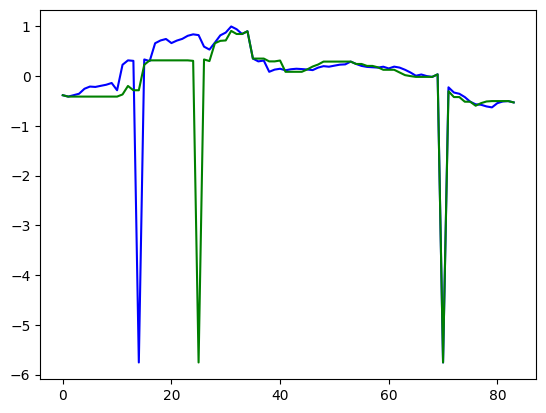

In [354]:
plt.plot(to_be_explained_instance, c='blue')
plt.plot(generated_cf.squeeze(), c='green', label='Generated CF')


In [355]:
# Experiment
if clf.predict(generated_cf)[0] != to_be_explained_instance_predicted_y:
    print("Matching")
    import experiment
    if_model = experiment.train_isolation_forest(X_train, random_seed)
    closeness_l1 = experiment.calculate_closeness(generated_cf, to_be_explained_instance, "l1")
    ## Closeness: L2
    closeness_l2 = experiment.calculate_closeness(generated_cf, to_be_explained_instance, "l2")
    ## Sparsity
    sparsity = experiment.calculate_sparsity(generated_cf, to_be_explained_instance)

    isolation_predict = experiment.predict_outlier_with_isolation_forest(if_model, generated_cf)
    print("Closeness_l1: ", closeness_l1, ", Closeness_l2: ", closeness_l2, ", Sparsity: ", sparsity, ", Out-of-distribution: ", isolation_predict)
else:
    print("Not Found")
## SSSS

from datetime import datetime
now = datetime.now()
print("Now: ", now)
print("Dataset: ", dataset_name)
print("Random Seed: ", random_seed)
print("To-be-explained_instance_id: ", instance_id, ", Predicted: ", to_be_explained_instance_predicted_y, ", Truth: ", to_be_explained_instance_label_y, ", Target: ", target_y)
print("(1) Training classifier " , classifier_name, " ......", clf)

1/1 [==============================] - 0s 21ms/step
Matching
Closeness_l1:  22.335999746780953 , Closeness_l2:  8.740477596932696 , Sparsity:  0.15476190476190477 , Out-of-distribution:  1
Now:  2023-08-17 13:24:49.002450
Dataset:  MoteStrain
Random Seed:  111
To-be-explained_instance_id:  222 , Predicted:  -1 , Truth:  -1 , Target:  1
(1) Training classifier  CNN  ...... CNNClassifier(random_state=111)


Saved.


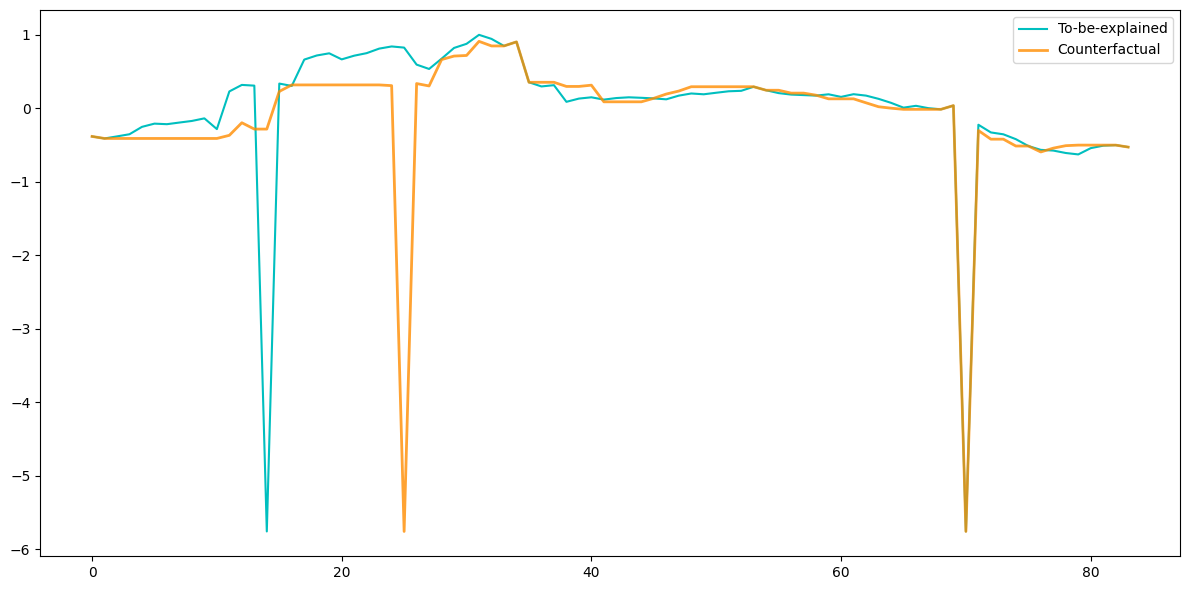

In [356]:
from visulization import *
plot_save_time_series(
                    generated_cf,
                    to_be_explained_instance, 
                    0,
                    0,
                    dataset_name=dataset_name, 
                    classifier_name=classifier_name, 
                    instance_id=instance_id, 
                    random_seed=random_seed,
                    timegan_id=0,
                    sp_idx=0,
                    is_save=True,
                    is_plot=True)

In [357]:
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), facecolor="1")
# plt.xlabel('Time')
    
# axes[0].plot(X_test[12], label = 'Query')
# axes[0].plot(X_train[24], label = 'NN')
# axes[0].legend(loc='upper right', fontsize=12) 
# axes[0].set_xlabel('Time', rotation=0, size=16, fontweight='bold')
# axes[0].set_ylabel('Value', rotation=90, size=16, fontweight='bold')   
    
# axes[1].plot(X_test[12], label = 'Query')
# axes[1].plot(X_train[4],alpha = 0.7, label = 'NUN-CF', color='red')
# axes[1].legend(loc='upper right', fontsize=12)
# axes[1].set_xlabel('Time', rotation=0, size=16, fontweight='bold')


# axes[2].plot(X_test[12], label = 'Query')
# axes[2].plot(generated_cf,alpha = 0.7, label = 'Generated CF', color='darkmagenta')
# axes[2].legend(loc='upper right', fontsize=12)
# axes[2].set_xlabel('Time', rotation=0, size=16, fontweight='bold')


# axes[0].text(-4,2.3,'A.', fontsize=22, fontweight='bold')
# axes[1].text(-4,2.3,'B.', fontsize=22, fontweight='bold')
# axes[2].text(-4,2.3,'C.', fontsize=22, fontweight='bold')

# #plt.savefig('./Images/DTW_DBA_EXAMPLE.pdf')